In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse
import numpy as np
from statsmodels.tsa.api import VAR, VARMAX


import utils


# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(
    covars_diff, should_diff=True, diff_order=1, should_scale=True, should_log=True
)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False, should_scale=True, should_log=True
)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(
    covars_diff_yoy, should_diff=True, diff_order=12, should_scale=True, should_log=True
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=True, should_log=True)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))


lags_past_covariates = {
        "US_UNEMPLOYMENT_RATE": [-3],
        "US_CPI": [-3],
        "US_TB_YIELD_3YRS": [-2],
        "YIELD_CURVE": [-1],
        "EXPINF10YR": [-1],
        "MICH": [-1],
        "US_TB_YIELD_5YRS": [-1],
        "NEWS_SENTIMENT": [-2],
        # "SNP_500": [-1]
}

covariates_scaled = covariates_scaled.drop_columns([c for c in covariates_scaled.columns if c not in lags_past_covariates.keys()])




def make_multivariate_time_series(ts, covariates, only_cpi=True):
    if only_cpi:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates["US_CPI"])
    else:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates)

    # Split the data into training and validation sets
    train_ts_scaled, val_ts_scaled = ts_multivariate.split_after(pd.Timestamp("2016-01-01"))

    # Reconvert to DataFrame since statsmodels does not support TimeSeries objects
    train = train_ts_scaled.pd_dataframe()
    validation = val_ts_scaled.pd_dataframe()
    history = pd.concat([train, validation])

    return train, validation, history


train, validation, history = make_multivariate_time_series(ts_scaled, covariates_scaled, only_cpi=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/Xavier/cdpq-ia/utils.py:225: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  autres = autres.apply(pd.to_numeric, errors="ignore")


In [93]:
train.head()

component,US_TB_YIELD_10YRS,US_TB_YIELD_3YRS,US_TB_YIELD_5YRS,EXPINF10YR,US_UNEMPLOYMENT_RATE,NEWS_SENTIMENT,YIELD_CURVE,MICH,US_CPI
DATE,,,,,,,,,
1981-01-31,-0.861807,-1.668717,-1.349843,0.061558,-0.017725,-1.924380,-1.555775,4.698217,0.948019
1981-02-28,2.093773,1.735330,1.900737,0.061558,-0.553047,-1.783316,-1.555775,4.006812,1.218175
1981-03-31,-0.215918,-0.327320,0.024028,0.061558,0.597897,-1.625248,-1.555775,2.931291,1.146243
1981-04-30,1.889633,1.582733,1.729350,0.061558,-0.169399,-1.383744,-1.555775,3.545874,1.094530
1981-05-31,1.418656,2.667928,1.878366,0.061558,-0.008803,-1.020066,-1.555775,3.008114,1.001285


# VAR Model

<Axes: xlabel='DATE'>

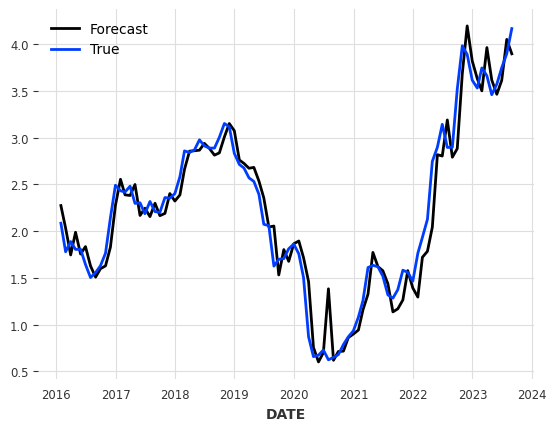

In [94]:
# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

    # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month
    model = VAR(hist_t)
    model_fit = model.fit(maxlags=1)

    # Forecast for t + 1
    y_pred = model_fit.forecast(hist_t.values[-model_fit.k_ar:], steps=1)[0][0]
    y_pred_unscaled = utils.unscale_series(TimeSeries.from_times_and_values(values=np.array([y_pred]), times=pd.DatetimeIndex([t], freq="ME")), pipeline, ts_scaled["US_TB_YIELD_10YRS"])
    y_pred_unscaled = y_pred_unscaled.pd_dataframe().rename(columns={"US_TB_YIELD_10YRS": "mean"})



    # print(y_pred.summary_frame())
    forecasts = pd.concat([forecasts, y_pred_unscaled])

# Revert the scaling
fore_unscaled = TimeSeries.from_dataframe(forecasts, value_cols=["mean"])

# Plot the forecast
fore_unscaled.plot(label="Forecast")
val_ts.plot(label="True")

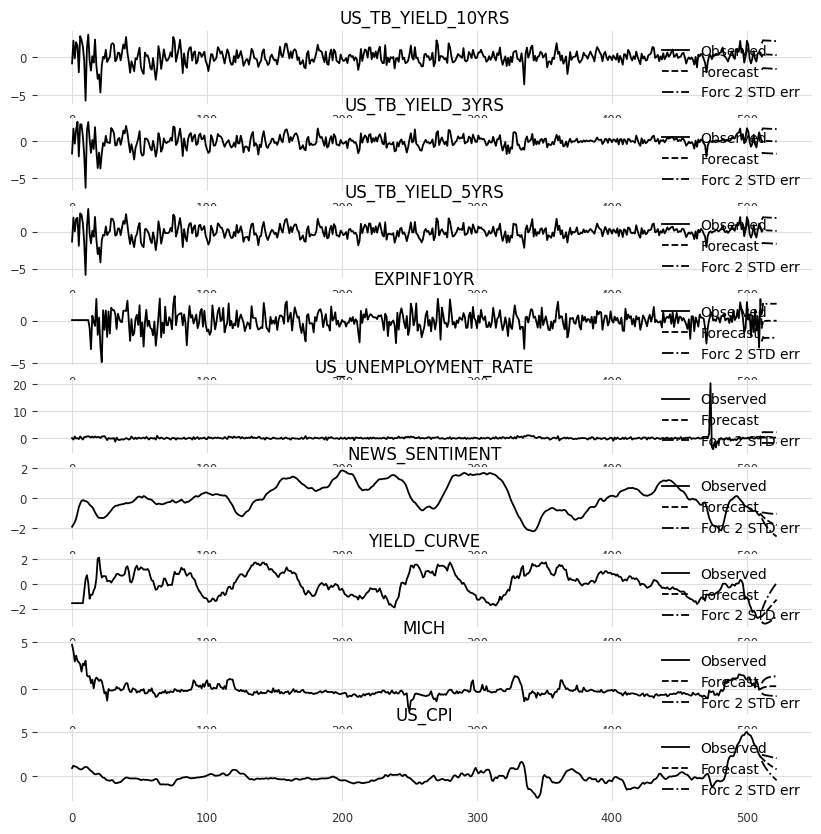

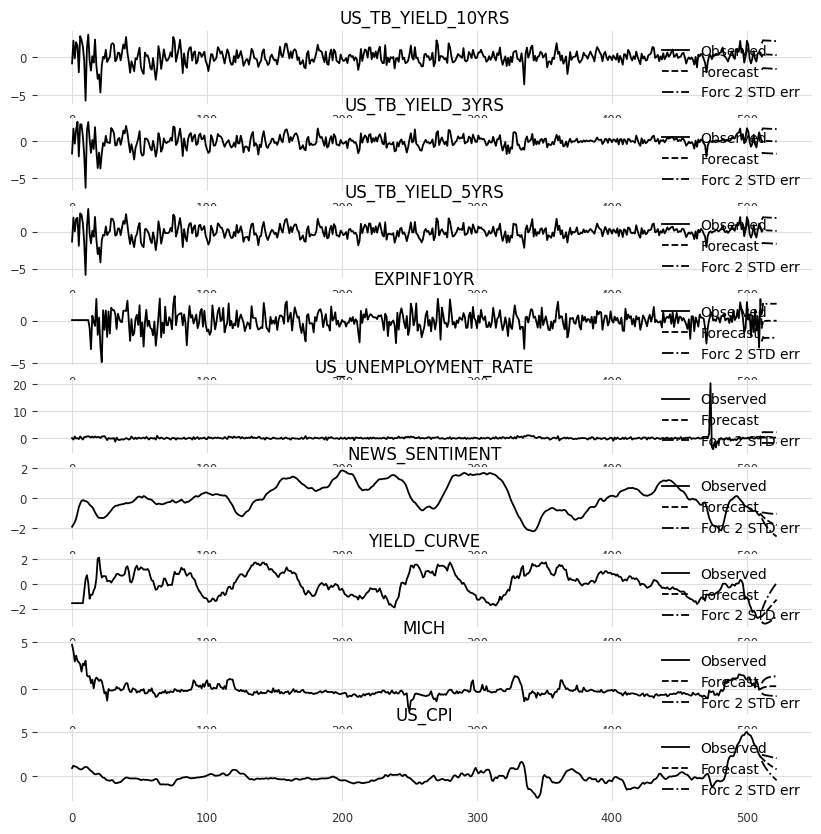

In [95]:
model_fit.plot_forecast(steps=12)

In [96]:
test_result = model_fit.test_causality(caused='US_TB_YIELD_10YRS', causing=['US_CPI'], kind='f', signif=0.05)
test_result.summary()

Test statistic,Critical value,p-value,df
0.02021,3.844,0.887,"(1, 4500)"


In [97]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 08, Jan, 2025
Time:                     10:29:01
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -21.5794
Nobs:                     510.000    HQIC:                  -22.0337
Log likelihood:          -729.636    FPE:                2.01226e-10
AIC:                     -22.3266    Det(Omega_mle):     1.68961e-10
--------------------------------------------------------------------
Results for equation US_TB_YIELD_10YRS
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.005461         0.039501           -0.138           0.890
L1.US_TB_YIELD_10YRS           -0.020818         0.210252           -0.099           0.921
L1.US_TB

In [98]:
# Compute the error metrics
print(f"MAPE: {mape(val_ts, fore_unscaled)}")
print(f"RMSE: {rmse(val_ts, fore_unscaled)}")
print(f"R2: {r2_score(val_ts, fore_unscaled)}")

MAPE: 9.128560475807813
RMSE: 0.22080752314497687
R2: 0.9373957998149777


In [64]:
norm = model_fit.test_normality()
norm.summary()

Test statistic,Critical value,p-value,df
2.815e+05,65.17,0.000,48


In [65]:
whiteness = model_fit.test_whiteness()
whiteness.summary()

Test statistic,Critical value,p-value,df
1.141e+04,5353.,0.000,5184


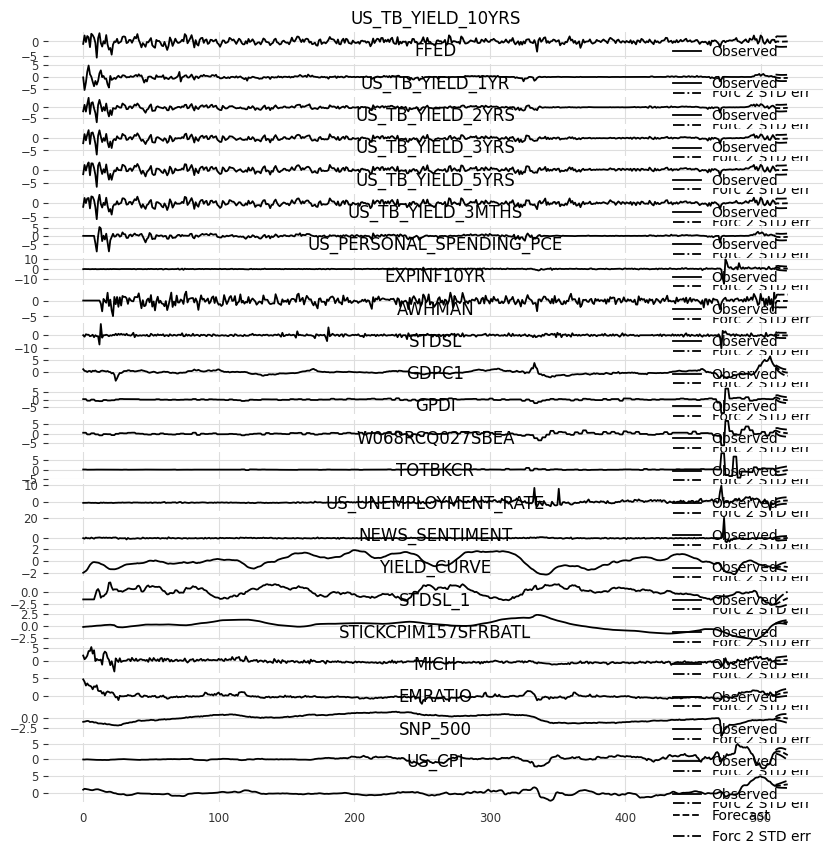

In [66]:
fig = model_fit.plot_forecast(10)

In [ ]:
from statsmodels.tsa.vector_ar.irf import IRAnalysis

t: IRAnalysis = model_fit.irf(10).plot(impulse="US_TB_YIELD_10YRS", response="US_TB_YIELD_10")

ValueError: 'US_TB_YIELD_10' is not in list

# SVAR

In [100]:
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse
import numpy as np
from statsmodels.tsa.api import VAR, VARMAX


import utils


# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(
    covars_diff, should_diff=True, diff_order=1, should_scale=True, should_log=True
)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False, should_scale=True, should_log=True
)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(
    covars_diff_yoy, should_diff=True, diff_order=12, should_scale=True, should_log=True
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1, should_scale=True, should_log=True)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))


lags_past_covariates = {
        "US_UNEMPLOYMENT_RATE": [-3],
        "US_CPI": [-3],
        "US_TB_YIELD_3YRS": [-2],
        "YIELD_CURVE": [-1],
        "EXPINF10YR": [-1],
        "MICH": [-1],
        "US_TB_YIELD_5YRS": [-1],
        "NEWS_SENTIMENT": [-2],
        "SNP_500": [-1]
}

covariates_scaled = covariates_scaled.drop_columns([c for c in covariates_scaled.columns if c not in lags_past_covariates.keys()])




def make_multivariate_time_series(ts, covariates, only_cpi=True):
    if only_cpi:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates["US_CPI"])
    else:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates)

    # Split the data into training and validation sets
    train_ts_scaled, val_ts_scaled = ts_multivariate.split_after(pd.Timestamp("2016-01-01"))

    # Reconvert to DataFrame since statsmodels does not support TimeSeries objects
    train = train_ts_scaled.pd_dataframe()
    validation = val_ts_scaled.pd_dataframe()
    history = pd.concat([train, validation])

    return train, validation, history


train, validation, history = make_multivariate_time_series(ts_scaled, covariates_scaled, only_cpi=False)

/Users/Xavier/cdpq-ia/utils.py:225: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  autres = autres.apply(pd.to_numeric, errors="ignore")


In [ ]:
# Make 10x10 matrix with 0 on upper triangle, 1 on diagonal and "E" on lower triangle
# The matrix should be symmetric
n = len(train.columns)
matrix = np.zeros((n, n), dtype=object)
for i in range(n):
    for j in range(n):
        if i == j:
            matrix[i, j] = 1
        if i > j:
            matrix[i, j] = "E"
matrix

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       ['E', 1, 0, 0, 0, 0, 0, 0, 0, 0],
       ['E', 'E', 1, 0, 0, 0, 0, 0, 0, 0],
       ['E', 'E', 'E', 1, 0, 0, 0, 0, 0, 0],
       ['E', 'E', 'E', 'E', 1, 0, 0, 0, 0, 0],
       ['E', 'E', 'E', 'E', 'E', 1, 0, 0, 0, 0],
       ['E', 'E', 'E', 'E', 'E', 'E', 1, 0, 0, 0],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E', 1, 0, 0],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 1, 0],
       ['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 1]], dtype=object)

In [108]:
import numpy as np
from statsmodels.tsa.api import SVAR
# Specify structural matrices
A = matrix  # Contemporaneous restrictions

# Fit the SVAR model
svar_model = SVAR(train, svar_type='A', A=A)  # Use 'B' for long-run restrictions
svar_results = svar_model.fit(maxlags=3, maxiter=10000, maxfun=10000)


KeyboardInterrupt: 

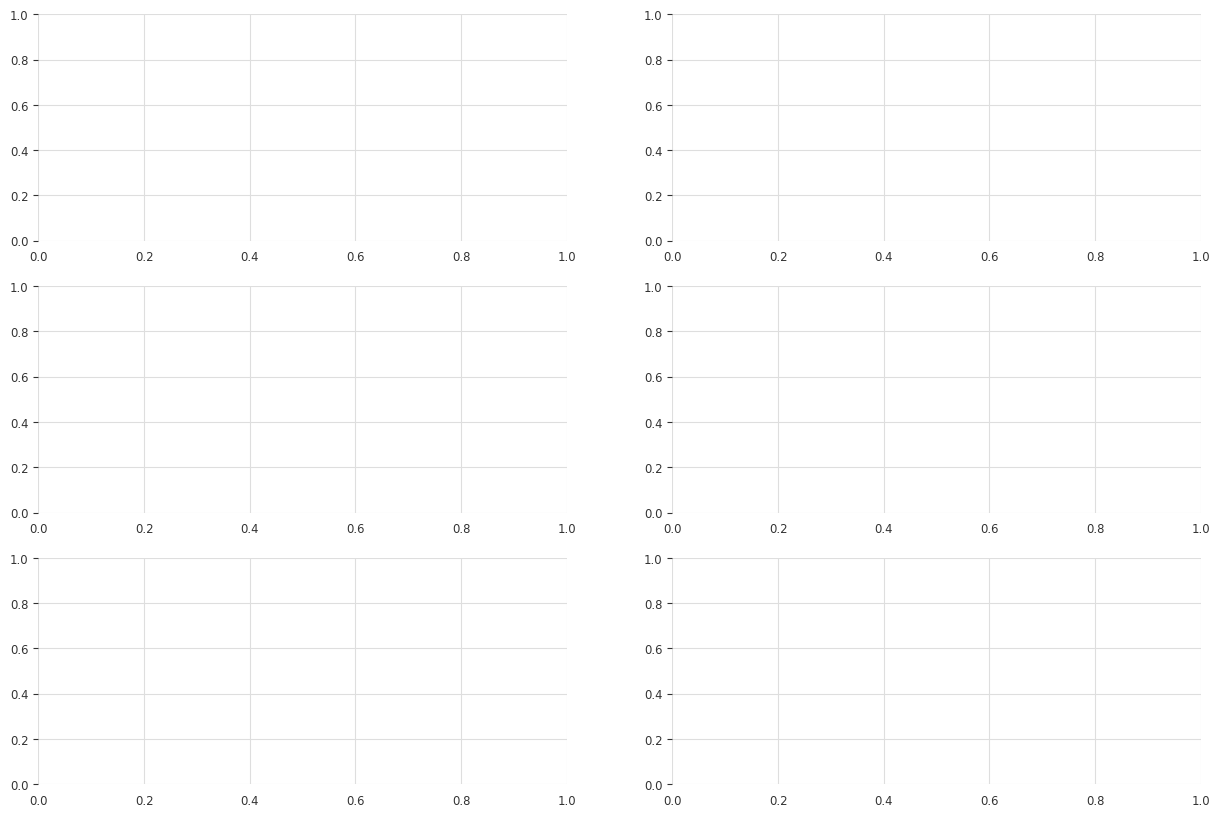

In [ ]:
# Save plot to png
import matplotlib.pyplot as plt
# plt.savefig("irf_plot.png")


for r in ["US_CPI", "SNP_500", "US_UNEMPLOYMENT_RATE", "GDPC1", "US_TB_YIELD_3YRS"]:
    svar_results.irf(periods=18).plot(impulse='US_TB_YIELD_10YRS', plot_stderr=True, response=r,
                         stderr_type='mc', repl=100)